Выделим регионы, которые сильно отличаются от контроля по расстоянию до ближайшей замены

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import scipy

sys.path.append('../src/')

import utils

In [14]:
# PATH_TO_DISTANCES = '../data/new_final_fantasy_Sat_May__8_13:54:58_2021.csv'
PATH_TO_DISTANCES = '../data/new_final_fantasy_Sat_Jun__5_20:28:29_2021.csv'

PATH_TO_REG_POSITIONS = '../data/regions_positions.npy'
PATH_TO_CONTROL_POSITIONS = '../data/control_regions_positions.npy'

PATH_TO_GENOME_ANNOT = '../data/gemone_structures_annot.csv'

# BASE_PATH = "../data/old_iwt2/iwt_dataset20_10_10000"  # wrong
BASE_PATH = "../data/_iwt_dataset20_10_10000"

In [15]:
gannot = pd.read_csv(PATH_TO_GENOME_ANNOT)
gannot['Pos'] -= 1
gannot.head(2)

,Pos,RefNuc,GenName,IsStem,SsPairs,NSubst,IsTRS
0,0,A,5UTR,NaN,NaN,89,0
1,1,T,5UTR,NaN,NaN,122,0


In [16]:
## load positions of sampled regions
sampled_regions = np.load(PATH_TO_REG_POSITIONS)
sampled_controls = np.load(PATH_TO_CONTROL_POSITIONS)

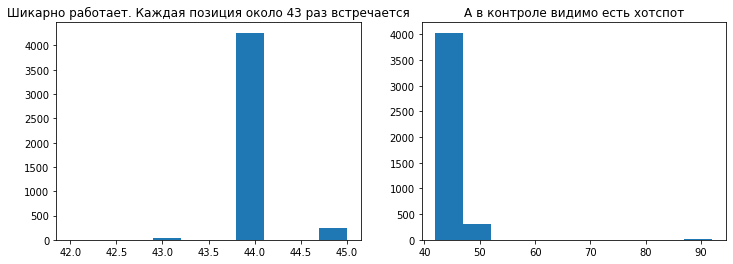

In [17]:
# check sampling quality
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.title('Шикарно работает. Каждая позиция около 43 раз встречается')
plt.hist(np.unique(sampled_regions.flatten(), return_counts=True)[1])
plt.subplot(122)
plt.title('А в контроле видимо есть хотспот')
plt.hist(np.unique(sampled_controls.flatten(), return_counts=True)[1])
plt.show()

In [18]:
# only 10 hot positions
np.sort(np.unique(sampled_controls.flatten(), return_counts=True)[1])[-11:]

array([47, 91, 91, 91, 91, 91, 92, 92, 92, 92, 92])

In [19]:
_1, _2 = np.unique(sampled_controls.flatten(), return_counts=True)
_1[_2 > 50]

array([9047, 9048, 9049, 9050, 9051, 9072, 9073, 9074, 9075, 9076])

---------

In [20]:
def read_bed_dists(lvl=1, dist=30000):
    PATH_TO_DIST1_ELEMENTS = f'{BASE_PATH}_{dist}_lvl-{lvl}_mode-more/files/distance1_elements.txt'
    PATH_TO_DIST1_CONTROLS = f'{BASE_PATH}_{dist}_lvl-{lvl}_mode-more/files/distance1_control.txt'

    distance1_elements_bed = pd.read_csv(
        PATH_TO_DIST1_ELEMENTS, 
        sep='\t', 
        header=None,
        names=['chr', '_start', '_end', 'int_st_1', 'int_st_2', 'int_st_3', 'int_st_4']
    )
    distance1_controls_bed = pd.read_csv(
        PATH_TO_DIST1_CONTROLS, 
        sep='\t', 
        header=None,
        names=['chr', '_start', '_end', 'int_st_1', 'int_st_2', 'int_st_3', 'int_st_4']
    )
    return distance1_elements_bed, distance1_controls_bed


distance1_elements_bed, distance1_controls_bed = read_bed_dists()

inte_stats = ['int_st_1', 'int_st_2', 'int_st_3', 'int_st_4']

In [21]:
distance1_elements_bed.head(2)

,chr,_start,_end,int_st_1,int_st_2,int_st_3,int_st_4
0,chr1,0,20,2757.288288,3004.134454,NaN,NaN
1,chr1,20,40,3840.305785,3276.692308,NaN,NaN


In [22]:
# distance1_elements_bed, distance1_controls_bed = read_bed_dists(4)

# plt.figure(figsize=(8, 6))
# sns.histplot(distance1_controls_bed[inte_stats].mean(axis=1), 
#              alpha=.4, label='Контроль (регионы без структур)', color='blue', bins=50, binrange=(0, 1000))
# sns.histplot(distance1_elements_bed[inte_stats].mean(axis=1), 
#              alpha=.5, label='Регионы вторичных структур', color='orange', bins=50, binrange=(0, 1000))

# plt.xlabel('Среднее расстояние между ближайшими заменами, нуклеотиды', fontsize=15)
# plt.ylabel('Количество регионов', fontsize=15)
# plt.legend(fontsize=11)
# plt.show()


# plt.figure(figsize=(8, 6))
# sns.histplot(distance1_controls_bed[inte_stats].mean(axis=1), 
#              alpha=.5, label='Контроль (регионы без структур)', 
#              bins=50, cumulative=True, binrange=(0, 1000), palette='pastel')
# sns.histplot(distance1_elements_bed[inte_stats].mean(axis=1), 
#              alpha=.5, label='Регионы вторичных структур', 
#              bins=50, cumulative=True, binrange=(0, 1000), palette='pastel')

# plt.xlabel('Среднее расстояние между ближайшими заменами, нуклеотиды', fontsize=15)
# plt.ylabel('Кумулятивная сумма количества', fontsize=15)
# plt.legend(fontsize=11)
# plt.show()

# plt.figure(figsize=(8, 6))
# sns.histplot(data=_df, x='dist_mean', hue='Регионы', palette='muted', bins=50, cumulative=True, )

# plt.xlabel('Среднее расстояние между ближайшими заменами, нуклеотиды', fontsize=15)
# plt.ylabel('Кумулятивная сумма количества', fontsize=15)
# plt.show()

In [286]:
def cdf_difference(x0, x1, n_bins=100, hrange=None, eps=10e-7, beauty=True):
    """https://matplotlib.org/stable/gallery/statistics/histogram_cumulative.html"""
    if hrange is None:
        xmin = min(min(x0), min(x1))
        xmax = max(max(x0), max(x1))
        hrange = (xmin, xmax)
        print(f'range = {(xmin, xmax)}')
    # "plot" the cumulative histogram
    n0, bins0, _ = plt.hist(x0, n_bins, hrange, density=True, histtype='step', cumulative=True)
    n1, bins1, _ = plt.hist(x1, n_bins, hrange, density=True, histtype='step', cumulative=True)
    plt.close()
    assert np.all(bins0 == bins1), f"{bins0}, {bins1}"
    
    division = n1 / (n0 + eps)
#     division = n0 / n1
    if beauty:
        division *= np.abs(n1 - n0)
    return bins0[1:], division

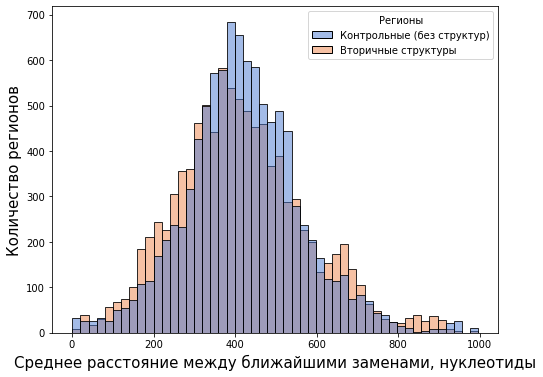

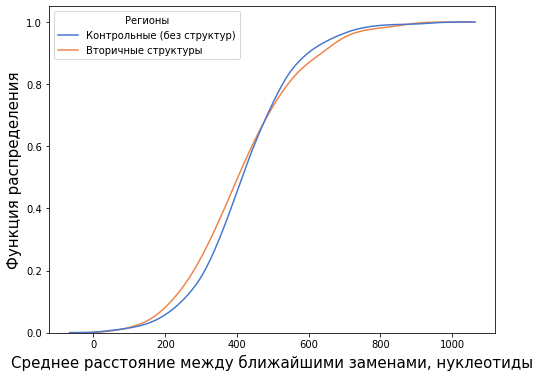

range = (1.0, 996.0)


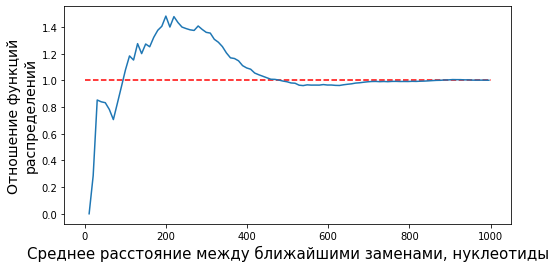

In [287]:
LVL = 4
DIST = 1000

distance1_elements_bed, distance1_controls_bed = read_bed_dists(LVL, dist=DIST)

_df1 = pd.DataFrame(distance1_controls_bed[inte_stats].mean(axis=1))
_df1.columns = ['dist_mean']
_df1['Регионы'] = 'Контрольные (без структур)'

_df2 = pd.DataFrame(distance1_elements_bed[inte_stats].mean(axis=1))
_df2.columns = ['dist_mean']
_df2['Регионы'] = 'Вторичные структуры'

_df = pd.concat([_df1, _df2])

fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot(data=_df, x='dist_mean', hue='Регионы', palette='muted', bins=50, ax=ax)

ax.set_xlabel('Среднее расстояние между ближайшими заменами, нуклеотиды', fontsize=15)
ax.set_ylabel('Количество регионов', fontsize=15)
# ax.legend(fontsize=12)
plt.show()

##########################################

plt.figure(figsize=(8, 6))
sns.kdeplot(data=_df, x='dist_mean', hue='Регионы', palette='muted', cumulative=True, common_norm=False)

# plt.vlines([150, 450], 0., 0.7, 'g', linestyles='dotted')

plt.xlabel('Среднее расстояние между ближайшими заменами, нуклеотиды', fontsize=15)
plt.ylabel('Функция распределения', fontsize=15)
plt.show()

##########################################

x0 = distance1_controls_bed[inte_stats].mean(axis=1).values
x1 = distance1_elements_bed[inte_stats].mean(axis=1).values

beauty = False
x, y = cdf_difference(x0, x1, 100, beauty=beauty)

plt.figure(figsize=(8, 4))
plt.plot(x, y)
plt.hlines(1, 0, DIST, 'r', linestyles='dashed')
# plt.vlines([150, 450], 0.5, 1.4, 'g', linestyles='dotted')
plt.xlabel('Среднее расстояние между ближайшими заменами, нуклеотиды', fontsize=15)
if beauty:
    plt.ylabel('$CDF_{stem} / CDF_{control} * |CDF_{stem} - CDF_{control}|$', fontsize=16)
else:
    plt.ylabel('Отношение функций\nраспределений', fontsize=14)
plt.show()

In [259]:
DIST = 1000
max_lvl = 8
graph_id = 1


pre_cald_diff = []
for LVL in range(1, max_lvl+1):
    distance1_elements_bed, distance1_controls_bed = read_bed_dists(LVL, dist=DIST)
    x0 = distance1_controls_bed[inte_stats].mean(axis=1).values
    x1 = distance1_elements_bed[inte_stats].mean(axis=1).values

    beauty = False
    x, y = cdf_difference(x0, x1, 100, beauty=beauty)
    pre_cald_diff.append((x,y))

range = (26.60358833422919, 890.0)
range = (15.98263075722092, 972.0)
range = (1.0833333333333335, 996.0)
range = (1.0, 996.0)
range = (1.0, 996.0)
range = (1.0, 991.0)
range = (1.0, 991.0)
range = (1.0, 991.0)


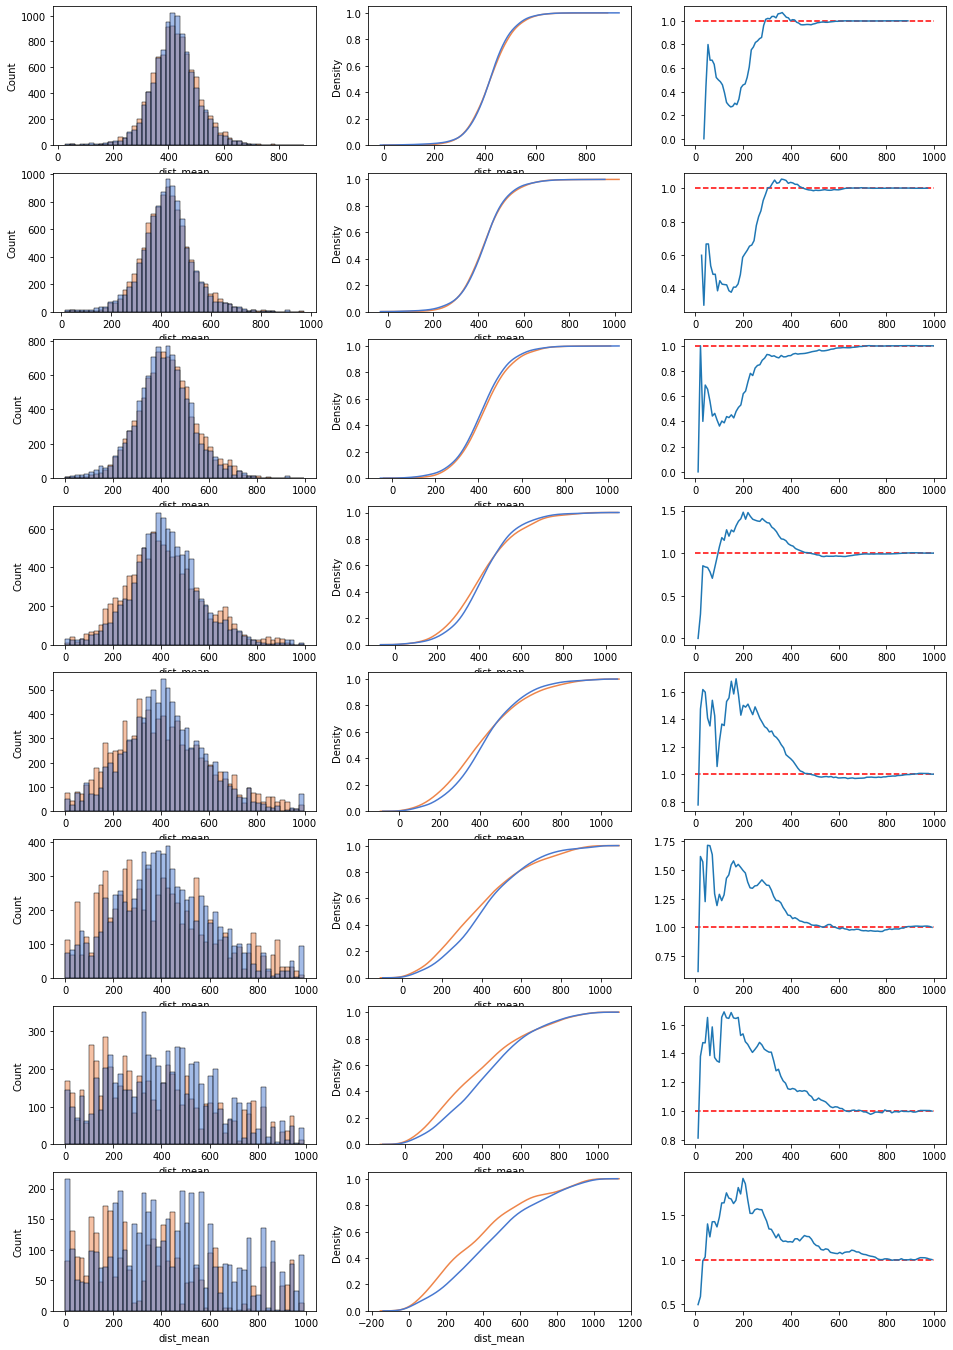

In [260]:
plt.figure(figsize=(16, 3*max_lvl))
for LVL in range(1, max_lvl+1):
    distance1_elements_bed, distance1_controls_bed = read_bed_dists(LVL, dist=DIST)

    _df1 = pd.DataFrame(distance1_controls_bed[inte_stats].mean(axis=1))
    _df1.columns = ['dist_mean']
    _df1['Регионы'] = 'Контрольные (без структур)'

    _df2 = pd.DataFrame(distance1_elements_bed[inte_stats].mean(axis=1))
    _df2.columns = ['dist_mean']
    _df2['Регионы'] = 'Вторичные структуры'

    _df = pd.concat([_df1, _df2])
    
    plt.subplot(max_lvl, 3, graph_id)
    sns.histplot(data=_df, x='dist_mean', hue='Регионы', palette='muted', bins=50, legend=False)

#     plt.xlabel('Среднее расстояние между ближайшими заменами, нуклеотиды', fontsize=15)
#     plt.ylabel('Количество регионов', fontsize=15)
    
    graph_id += 1
    ##########################################
    
    plt.subplot(max_lvl, 3, graph_id)
    sns.kdeplot(data=_df, x='dist_mean', hue='Регионы', palette='muted', 
                cumulative=True, common_norm=False, legend=False)

#     plt.xlabel('Среднее расстояние между ближайшими заменами, нуклеотиды', fontsize=15)
#     plt.ylabel('Функция распределения', fontsize=15)

    graph_id += 1
    ##########################################

    beauty = False
    x, y = pre_cald_diff[LVL - 1]
    
    plt.subplot(max_lvl, 3, graph_id)
    plt.plot(x, y)
    plt.hlines(1, 0, DIST, 'r', linestyles='dashed')
#     plt.xlabel('Среднее расстояние между ближайшими заменами, нуклеотиды', fontsize=15)
#     if beauty:
#         plt.ylabel('$CDF_{stem} / CDF_{control} * |CDF_{stem} - CDF_{control}|$', fontsize=16)
#     else:
#         plt.ylabel('Отношение функций\nраспределений', fontsize=14)
    graph_id += 1
    
plt.show()

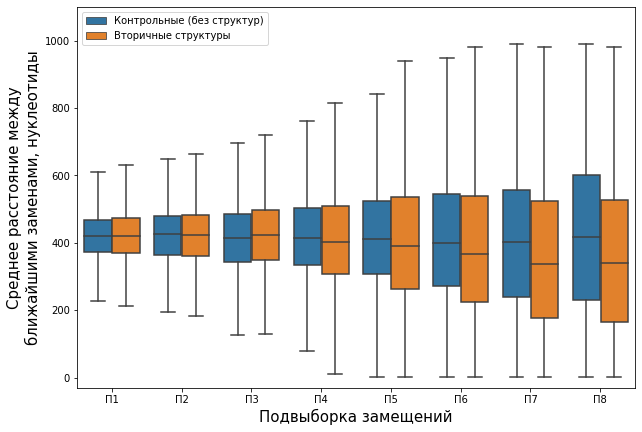

In [263]:
coll = []

for LVL in range(1, max_lvl+1):
    distance1_elements_bed, distance1_controls_bed = read_bed_dists(LVL, dist=DIST)
    
    cont_reg_dists = distance1_controls_bed[inte_stats].mean(axis=1)
    elem_reg_dists = distance1_elements_bed[inte_stats].mean(axis=1)
    
    _df1 = pd.DataFrame(cont_reg_dists)
    _df1.columns = ['dist_mean']
    _df1['Регионы'] = 'Контрольные (без структур)'

    _df2 = pd.DataFrame(elem_reg_dists)
    _df2.columns = ['dist_mean']
    _df2['Регионы'] = 'Вторичные структуры'

    _df = pd.concat([_df1, _df2])
    _df['Подвыборка'] = LVL
    coll.append(_df)

plt.figure(figsize=(10, 7))
flierprops = dict(marker=None, markerfacecolor='red', markersize=1,
                  linestyle='none', markeredgecolor='white', alpha=.5)
sns.boxplot(data=pd.concat(coll), y='dist_mean', x='Подвыборка', hue='Регионы', flierprops=flierprops)

plt.xlabel('Подвыборка замещений', fontsize=15)
plt.ylabel('Среднее расстояние между\nближайшими заменами, нуклеотиды', fontsize=15)
plt.xticks(ticks=range(8), labels=[f'П{i}' for i in range(1, 9)])
plt.ylim((-30, 1100))
plt.legend(loc='upper left')
plt.show()

In [236]:
np.round([x[x['Регионы'] == 'Вторичные структуры'].dist_mean.median() for x in coll], 2)

array([2867.31, 3434.64, 3102.81, 2783.96, 2449.11, 2130.  , 1812.9 ,
       1704.5 ])

In [235]:
np.round([x[x['Регионы'] == 'Контрольные (без структур)'].dist_mean.median() for x in coll], 2)

array([2828.46, 3365.79, 2978.26, 2689.37, 2442.29, 2027.87, 1782.5 ,
       1303.43])

In [80]:
hill_positions = sampled_regions[(x1 >= 2000) & (x1 <= 5000)].flatten()

In [82]:
from utils import read_ss_file

SEC_STRUCT_PATH_PLUS = '../data/structure_data/SARSCoV2-RNA_from_site_plus_0based.ss'

ss_regions = read_ss_file(SEC_STRUCT_PATH_PLUS)
_ss_regions_pos = [np.arange(ss[1], ss[2] + 1) for ss in ss_regions]
ss_positions = [x for y in _ss_regions_pos for x in y]

ss_pos2ss_idx = dict(zip(ss_positions, range(len(ss_positions))))
ss_idx2ss_pos = dict(enumerate(ss_positions))

In [83]:
free_pos = [x for y in [np.where(np.array(ss[5]) != 1)[0] + ss[1] for ss in ss_regions] for x in y]
free_pos_idx = [ss_pos2ss_idx[x] for x in free_pos]

In [84]:
hill_positions_idx = [ss_pos2ss_idx[x] for x in hill_positions]

In [85]:
# genes in ss idx
reduced_gannot = gannot[gannot.Pos.isin(ss_positions)]
genes = [x for x in reduced_gannot.GenName.unique() if '_' not in x]
genes_start_idx = dict(reduced_gannot.groupby('GenName').Pos.min())
genes_end_idx = dict(reduced_gannot.groupby('GenName').Pos.max())

# replace to pos idx
genes_start_idx = {k: ss_pos2ss_idx[v] for k, v in genes_start_idx.items()}
genes_end_idx = {k: ss_pos2ss_idx[v] for k, v in genes_end_idx.items()}

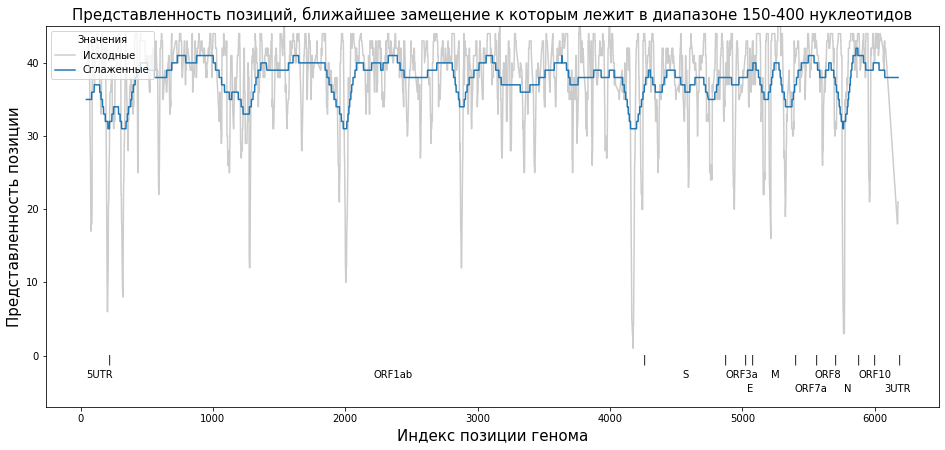

In [86]:
from scipy.interpolate import make_interp_spline, BSpline
from scipy.ndimage.filters import gaussian_filter1d


plt.figure(figsize=(16, 7))
# pd.Series(hill_positions_idx).plot.hist(bins=1000)
_x, _y = np.unique(hill_positions_idx, return_counts=True)
plt.plot(_x, _y, '-k', alpha=.2, label='Исходные')

# 100 represents number of points to make between min and max
# xnew = np.linspace(_x.min(), _x.max(), 50)[:-2]
# spl = make_interp_spline(_x, _y, k=3)  # type: BSpline
# power_smooth = spl(xnew)
# plt.plot(xnew, power_smooth, label='Сглаженные')

# Smoothed
ysmoothed = gaussian_filter1d(_y, sigma=30)
plt.plot(_x, ysmoothed, label='Сглаженные')

# free pos indication
# _fp = np.array([[x,y] for x, y in zip(_x, _y) if x in set(free_pos_idx)])
# plt.plot(_fp[:, 0], _fp[:, 1], '.r', label='Свободные позиции', alpha=.3)

# add genes annotation
rotation = 0
shift = False
for gene in genes:
    st = genes_start_idx[gene]
    end = genes_end_idx[gene]
    gpos = (st + end) // 2 - 10 if gene in ['ORF1ab', 'S', 'M', 'N', '3UTR'] else st
    plt.text(end, -1, '|')
    plt.text(gpos, -3 - int(shift)*2, gene, rotation=rotation)
    if end > genes_end_idx['S']:
        shift = not shift


plt.ylim(-7, 45)
plt.title(
    'Представленность позиций, ближайшее замещение к которым лежит в диапазоне 150-400 нуклеотидов', 
    fontsize=15,
)
plt.xlabel('Индекс позиции генома', fontsize=15)
plt.ylabel('Представленность позиции', fontsize=15)
plt.legend(loc='upper left', title='Значения')
plt.show()

### Make in-depth review

In [149]:
def cdf_difference(x0, x1, n_bins=100, hrange=None, eps=10e-7, beauty=True):
    """https://matplotlib.org/stable/gallery/statistics/histogram_cumulative.html"""
    if hrange is None:
        xmin = min(min(x0), min(x1))
        xmax = max(max(x0), max(x1))
        hrange = (xmin, xmax)
        print(f'range = {(xmin, xmax)}')
    # "plot" the cumulative histogram
    n0, bins0, _ = plt.hist(x0, n_bins, hrange, density=True, histtype='step', cumulative=True)
    n1, bins1, _ = plt.hist(x1, n_bins, hrange, density=True, histtype='step', cumulative=True)
    plt.close()
    assert np.all(bins0 == bins1), f"{bins0}, {bins1}"
    
    division = n1 / (n0 + eps)
#     division = n0 / n1
    if beauty:
        division *= np.abs(n1 - n0)
    return bins0[1:], division


def count_level_curves(beauty=False, dist=30000):
    all_cols = ['chr', '_start', '_end', 'int_st_1', 'int_st_2']
    inte_stats = ['int_st_1', 'int_st_2']
    in_depth_cdfs = []
    
    for elvl in range(1, 13 + 0):
        path_to_elements = f'{BASE_PATH}_{dist}_lvl-{elvl}_mode-more/files/distance1_elements.txt'
        path_to_controls = f'{BASE_PATH}_{dist}_lvl-{elvl}_mode-more/files/distance1_control.txt'
        if elvl == 13:
            path_to_elements = f'{BASE_PATH}_{dist}_lvl-1_mode-equal/files/distance1_elements.txt'
            path_to_controls = f'{BASE_PATH}_{dist}_lvl-1_mode-equal/files/distance1_control.txt'
            
        distance1_elements_bed = pd.read_csv(
            path_to_elements, 
            sep='\t', 
            header=None,
            names=all_cols
        )
        distance1_controls_bed = pd.read_csv(
            path_to_controls, 
            sep='\t', 
            header=None,
            names=all_cols
        )
        x0 = distance1_controls_bed[inte_stats].mean(axis=1).values
        x1 = distance1_elements_bed[inte_stats].mean(axis=1).values

        x, y = cdf_difference(x0, x1, 50, (1, dist), beauty=beauty)

        in_depth_cdfs.append((x, y))
    return in_depth_cdfs

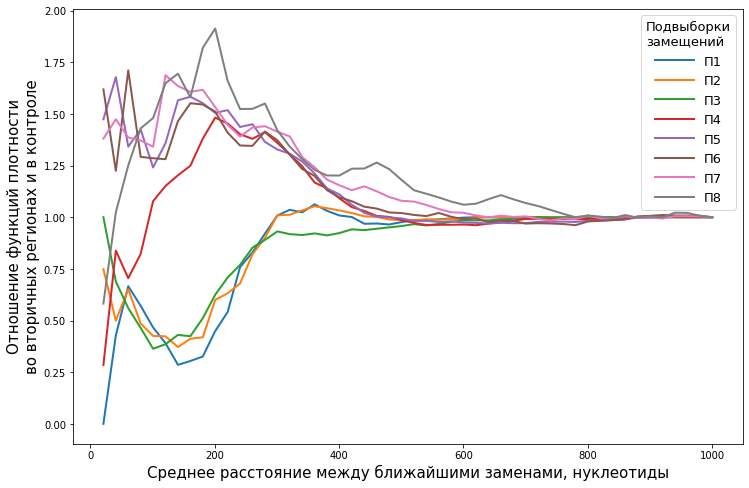

In [257]:
DIST = 1000
beauty = False
in_depth_cdfs = count_level_curves(beauty, dist=DIST)

plt.figure(figsize=(12, 8))
for i, (x, y) in enumerate(in_depth_cdfs[:8], 1):
    if i <= -1:
        plt.plot(x, y, '--', label=f"П{i}", linewidth=2)
    else:
        plt.plot(x, y, label=f"П{i}", linewidth=2)


# x, y = in_depth_cdfs[-1]
# plt.plot(x, y, label="only terminals", linewidth=2)

if beauty:
    plt.ylabel('$CDF_{stem} / CDF_{control} * |CDF_{stem} - CDF_{control}|$', fontsize=16)
else:
    plt.ylabel('Отношение функций плотности\nво вторичных регионах и в контроле', fontsize=15)
#     plt.hlines(1, 0, 500, 'k', linestyles='dotted')
#     plt.vlines([120, 220], 0.6, 1.5, 'k', linestyles='dotted')

    
plt.xlabel('Среднее расстояние между ближайшими заменами, нуклеотиды', fontsize=15)
plt.legend(fontsize=13, title="Подвыборки\nзамещений", 
           title_fontsize=13, fancybox=True, handlelength=3, loc='upper right')
# plt.ylim((0, 2))
plt.show()

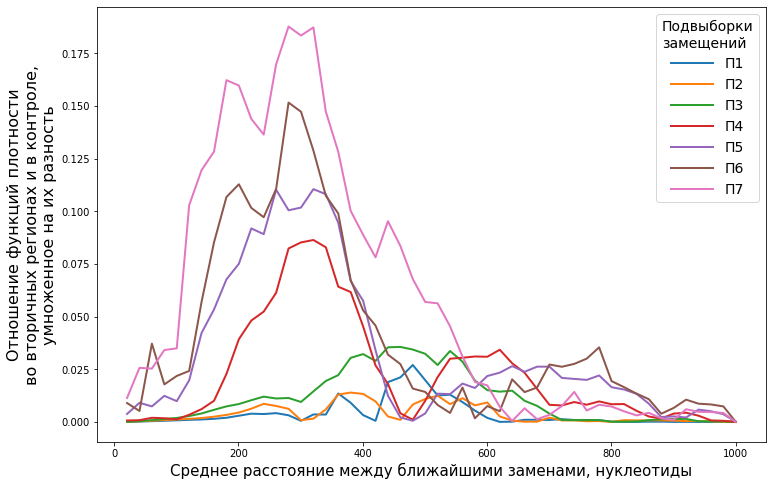

In [258]:
beauty = True
in_depth_cdfs = count_level_curves(beauty, dist=DIST)

plt.figure(figsize=(12, 8))
for i, (x, y) in enumerate(in_depth_cdfs[:7], 1):    
    if i <= -1:
        plt.plot(x, y, '--', label=f"П{i}", linewidth=2)
    else:
        plt.plot(x, y, label=f"П{i}", linewidth=2)


# x, y = in_depth_cdfs[-1]
# plt.plot(x, y, label=f"only terminals", linewidth=2)

if beauty:
#     plt.ylabel('$CDF_{stem} / CDF_{control} * |CDF_{stem} - CDF_{control}|$', fontsize=16)
    plt.ylabel('Отношение функций плотности\nво вторичных регионах и в контроле,\nумноженное на их разность', 
               fontsize=16)
    
plt.xlabel('Среднее расстояние между ближайшими заменами, нуклеотиды', fontsize=15)
plt.legend(fontsize=14, title="Подвыборки\nзамещений", title_fontsize=14, fancybox=True, handlelength=3)
plt.show()

In [38]:
print([x[np.argmax(y)] for x, y in in_depth_cdfs[:8]])

[480.52, 380.62, 460.54, 320.68, 260.74, 280.72, 280.72, 200.8]


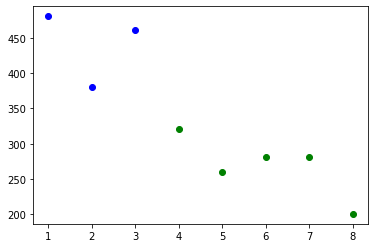

In [39]:
# kk = [190, 190, 180, 190, 170, 150]
kk = [x[np.argmax(y)] for x, y in in_depth_cdfs[:8]]
plt.plot([1,2,3], kk[:3], 'ob')
plt.plot([4,5,6,7,8], kk[3:], 'og')

--------------

Фильтрация дистансов (терминаль, претерминаль...)

In [75]:
from ete3 import PhyloTree
from utils import node_parent


def add_edge_level_to_table(substitutions: pd.DataFrame):
    TREE_PATH = "../data/mulal_gisaid_2021-01-22.filtered.twice.fasta.prank.anc.dnd"
    tree = PhyloTree(TREE_PATH, format=1)
    
    edge_levels = dict()

    for leaf in tree.iter_leaves():
        cur_level = 1
        parent = leaf    
        while parent != tree:
            parent = node_parent(leaf)
            pair = (parent.name, leaf.name)
            edge_levels[pair] = cur_level

            leaf = parent
            cur_level += 1

    assert len(edge_levels) == len(tree.get_descendants())  # E = V - 1
    
    substitutions['edge_level'] = substitutions.apply(
        lambda r: edge_levels[(r.parent_node, r.child_node)], axis=1)
    
    return substitutions


# distances = pd.read_csv('../data/new_final_fantasy_Sat_May__8_13:54:58_2021.csv')
# add_edge_level_to_table(distances).to_csv('../data/distances_25-05-21.csv', index=None)

In [76]:
distances = pd.read_csv('../data/distances_25-05-21.csv')
max_distance = 500
distances = distances[distances.primary_dist2nearest < max_distance]

print(distances[distances.edge_level >= 1].shape)
print(distances[distances.edge_level >= 2].shape)
print(distances[distances.edge_level >= 3].shape)
print(distances[distances.edge_level >= 4].shape)

(167599, 10)
(58513, 10)
(30255, 10)
(14767, 10)


Cтарый метод через узлы, а не ребра

In [82]:
distances[distances.edge_level >= 12]

,pair_idx,pos,parent_nucl,child_nucl,stype,primary_dist2nearest,secondary_dist2nearest,parent_node,child_node,edge_level
7498,1372,23310,T,G,0,275,245,#52366#,#51230#,12
7499,1372,23585,G,A,0,275,245,#52366#,#51230#,12
113038,19440,18534,G,A,0,212,212,#53474#,#53374#,12
113039,19440,18746,C,T,0,212,191,#53474#,#53374#,12
113040,19440,19010,T,C,0,264,191,#53474#,#53374#,12
113042,19440,21776,A,G,0,405,405,#53474#,#53374#,12
113043,19440,22181,A,G,0,405,405,#53474#,#53374#,12
139802,23766,23706,T,C,0,24,24,#54318#,#54300#,12
139803,23766,23730,C,T,8,24,24,#54318#,#54300#,12
488815,81714,10137,T,C,0,185,90,#49628#,#49058#,12


In [34]:
distances = pd.read_csv(PATH_TO_DISTANCES)
max_distance = 500
distances = distances[distances.primary_dist2nearest < max_distance]

terminal_nodes = distances[
    ~distances.child_node.str.startswith('#')].child_node.unique()
pre_terminal_nodes = distances[
    ~distances.child_node.str.startswith('#')].parent_node.unique()
pre_pre_terminal_nodes = distances[
    ~distances.child_node.isin(set(pre_terminal_nodes))].parent_node.unique()
pre_pre_pre_terminal_nodes = distances[
    ~distances.child_node.isin(set(pre_pre_terminal_nodes))].parent_node.unique()
pre_pre_pre_pre_terminal_nodes = distances[
    ~distances.child_node.isin(set(pre_pre_pre_terminal_nodes))].parent_node.unique()

print(distances.shape)
distances = distances[~distances.child_node.isin(terminal_nodes)]
print(distances.shape)
distances = distances[~distances.child_node.isin(pre_terminal_nodes)]
print(distances.shape)
distances = distances[~distances.child_node.isin(pre_pre_terminal_nodes)]
# distances = distances[~distances.child_node.isin(pre_pre_pre_terminal_nodes)]
# distances = distances[~distances.child_node.isin(pre_pre_pre_pre_terminal_nodes)]
print(distances.shape)

(167599, 9)
(58513, 9)
(27677, 9)
(17284, 9)


### Plot MutRate on ss and control 

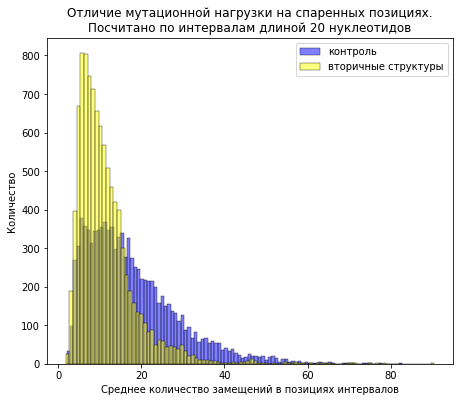

In [79]:
PATH_TO_DIST1_ELEMENTS = '../data/iwt_dataset20_10_10000_500_lvl-1_mode-more/files/subst_count__elements.txt'
PATH_TO_DIST1_CONTROLS = '../data/iwt_dataset20_10_10000_500_lvl-1_mode-more/files/subst_count__control.txt'

distance1_elements_bed = pd.read_csv(
    PATH_TO_DIST1_ELEMENTS, 
    sep='\t', 
    header=None,
    names=['chr', '_start', '_end', 'int_st_1', 'int_st_2', 'int_st_3', 'int_st_4']
)
distance1_controls_bed = pd.read_csv(
    PATH_TO_DIST1_CONTROLS, 
    sep='\t', 
    header=None,
    names=['chr', '_start', '_end', 'int_st_1', 'int_st_2', 'int_st_3', 'int_st_4']
)
inte_stats = ['int_st_1', 'int_st_2', 'int_st_3', 'int_st_4']

plt.figure(figsize=(16, 6))
plt.subplot(121)
sns.histplot(distance1_controls_bed[inte_stats].mean(axis=1), 
             alpha=.5, label='контроль', color='blue', bins=100)
sns.histplot(distance1_elements_bed[inte_stats].mean(axis=1), 
             alpha=.5, label='вторичные структуры', color='yellow', bins=100)
plt.xlabel('Среднее количество замещений в позициях интервалов')
plt.ylabel('Количество')
plt.title('Отличие мутационной нагрузки на спаренных позициях.\nПосчитано по интервалам длиной 20 нуклеотидов')
plt.legend()

plt.show()

In [21]:
xc = distance1_controls_bed[inte_stats].mean(axis=1).values
xr = distance1_elements_bed[inte_stats].mean(axis=1).values

In [88]:
_data = pd.DataFrame(
    np.concatenate(
        (
            np.concatenate(([xc], [['Контроль \n(регионы без структрур)']*len(xc)]), axis=0),
            np.concatenate(([xr], [['Вторичные структуры']*len(xr)]), axis=0)
        ),
        axis=1
    ).T,
    columns=['values', 'type'],
)

_data['values'] = _data['values'].astype(np.float)

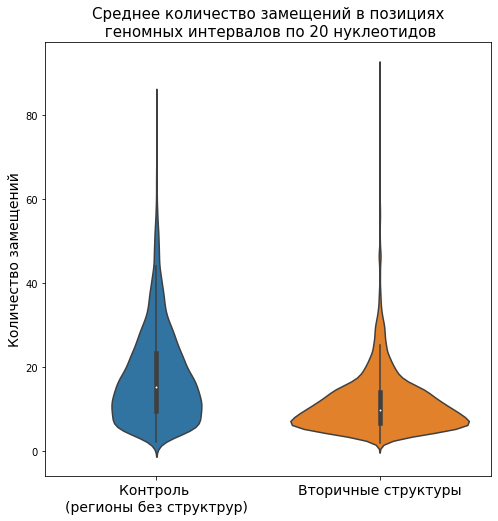

In [89]:
plt.figure(figsize=(8, 8))
sns.violinplot(data=_data, y='values', x='type')
plt.title('Среднее количество замещений в позициях\n геномных интервалов по 20 нуклеотидов', fontsize=15)
plt.xlabel('')
plt.ylabel('Количество замещений', fontsize=14)
plt.xticks(fontsize=14)
plt.show()

Проверим фичи на пригодность, замена тестированию.....

In [295]:
distances = pd.read_csv(PATH_TO_DISTANCES)
max_distance = 500
distances = distances[distances.primary_dist2nearest < max_distance]
distances = distances[distances.child_node.str.startswith('#')]
dists = distances.groupby('pos')['primary_dist2nearest'].apply(list)
pos2dist = dict(dists)

idx = np.random.randint(0, 10000-1)
interval_pos = sampled_regions[idx][:5]
idist_collection = [pos2dist[pos] for pos in interval_pos if pos in pos2dist]
idist = [d for pos_dists in idist_collection for d in pos_dists]
assert np.mean(idist) == distance1_elements_bed.iloc[idx, 3], (
    "calculated feature dist1 doesn't match to true value"
)

AssertionError: calculated feature dist1 doesn't match to true value